# 23 Long Term Treatment Effects

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

## Climbing the Right Hill

Let's take a moment to review where we are at and what we've learned. First, we've learned to estimate the average treatment effect

$$
E[Y_1 - Y_0] \ \text{or} \ E[\partial{Y(t)}]
$$

This alowed us to say with confidence what was the effect size of our interventions on some target outcome we wished to change. The ATE tells us what would hapen, on average, if we change the treatment for everyone. For example, say the ATE of increasing prices in BRL 1.00 is decreasing products sold per month in 2 units. This would mean that, on average, customers would by 2 fewer products per month than they would have in the price didn't change. This **does not** mean that every customer will buy 2 fewer units. Some might still by the same ammount. Some might by 10 units less. But, averaging all that out, sales should decrease 2 units. 

![img](./data/img/long-term-effect/ate.png)

After we covered the ATE, we learned about the conditional average treatment effect, or treatment effect heterogeneity

$$
E[Y_1 - Y_0 | X] \ \text{or} \ E[\partial{Y(t)}|X]
$$

where \\(X\\) is unit level caracteritics. The CATE alowed us to take into account that units respond differently to the same treatment. For example, some customers might not be very sensitive to price increases while others might be super sensitive. Modeling the conditional average treatment effect allow us to estimate this difference in sensitivity to the treatment on a unit level. 

![img](./data/img/long-term-effect/cate.png)

CATE estimation is also incredably powerfull because it allws us to personalise the treatment in a sound manner. We can give different treatments to different customers based on how well they respond to it. For example, we can increase price only for customers with high income level that are not very sensitive to price increases.

All in all, we can see that causal inference is an amazing tool to optimise any business strategy. With the ATE, we can understand which course of action or intervention would be better on average. With CATE we can personalise different interventions for different units. 

So, we've covered how to estimate the impact of a treatment \\(T\\), how that impact can be differentiated by covariates \\(X\\), but we still haven't talked much about \\(Y\\). In my head, that is mildly concerning. We saw how causal inference can be an incredible tool for hill climbing a business objective, but all of it can be for nothing if we pick the wrong hill to climb.

[MEME]

Deciding the right thing to optimize is probably the most chalanging part of any new data science project, so I can't promisse an ultimate solution for everything. But I do hope that by discussing it, you will get a valuable intuition about how to approach the problem and the most common tools at your disposal. In this chapter, I'll walk you through the process of thinking about a solid \\(Y\\) to optimise and the causal inference chalanges that will come with it.

## Treatment Effect Overt Time
 
Consider the ubiquitous problem of deciding if some investment is worth it. Here, investment is a general term. It can be an investment in customer service to delight your customers, or an investment in marketing to acquire new customers, or an investment in management training. In any case, deciding to invest or not is, fundamentally, a causal inference problem. You have to consider what would happen under the investment (\\(Y_1\\)), contrast that with what would happen unde no investment (\\(Y_0\\)) and contrast both (\\(Y_1 - Y_0\\)). Or, in continuous case, you would like to know what would happen under different invested ammounts \\(Y_t\\)

The problem is that some investments are often for the long term. A marketing strategy now can change how your customers view your company for a long time. The same goes for training your employees for better customer service. Even small things, like a price inscrease for the summer season can have lasting effects. So, one fundamental question we need to answer when thinking about what outcome we wish to impact with our treatment is how long do we need to wait for that outcome to mature?

To make things more concrete, let's say you are a big retail tech company. Your objective is to maximize products sold on your plataform. Let's say you run an experiment treating a random half of your customers (blue). The treatment is some big and expensive targeted marketing strategy. And let's say that, if you wait long enoutgh, you reach a time period where there is no longer a difference between treated and control group. If we plot product sold by customers over time, we would see something like this:

![img](./data/img/long-term-effect/te-over-time.png)


It is clear that the treatment effect is positive. Treated and control groups are comparable, so there is no bias. The outcome of the treated shoots up after the treatment at period \\(t_2\\) and it stays different from the control group up untill about period \\(t_8\\). The average treatment effect in each period \\(t\\) is \\(E[Y|D=1, t=t] - E[Y|D=0, t=t]\\) and the total effect is the sum of this terms over time

$$
\sum_{t=0}^{t=T} E[Y|D=1, t=t] - E[Y|D=0, t=t]
$$
 
All seems fine right? No trouble here. That's because we didn't said what unit is \\(t\\) in. For instance, if it is days, than, to see the entire treatment effect, all we have to do is wait 6 days after the treatment, from day 2 to day 8. But what if \\(t\\) is in months? Then, after the treatment, we would have to wait six months before we capture the entirety of the treatment effect. And what if \\(t\\) is in months? Now we are talking about long term treatment effects! 

As you can see, when we start to consider the fact that the treatment effect is not instantaneous, but it spans a (possibly long) period of time, we quickly find ourselves in troubled waters. On one hand, we wish to know the treatment effect in its entirety, specially if the treatment is an expensive investment. We want to know how much we can pay for it and still make a proft. On the other hand, we don't want or even can't wait a ridiculous ammount of time to see the treatment effect. In the industry, treatment effect estimating is often a precious input for decision making and some decisions simply can't wait that long. 


## The Cohort View

All right, all right. The fact that the treatment effect takes time to mature is indeed a problem. But only when that time to maturity is long. But what about the cases where we can wait to see the entire treatment effect, either because it takes a relativly short time to mature or because we don't need to make any timely decision? In those cases, long term treatment effect isn't a prblem, right?

Well... It depends. If the treatment is done only once for everyone, like a big snapshot, then yes, long term tretment effect is not a problem. You will be able to see the entire treatment effect and go on with your life. But one time treatment is not usually how and intervention gets applied in the industry. What usually happens is that a company usually has new customers comming in all the time. In our retail tech example, this would mean that, every period of time, a new group of customers is joining our plataform. **We call each of those groups a cohort**.

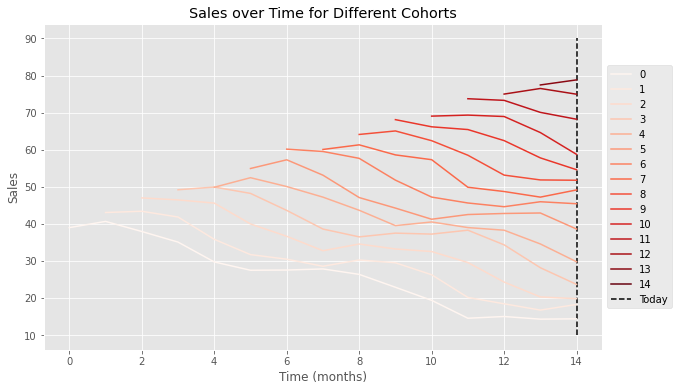

In [270]:
time_periods = 15

n=100

cohorts = pd.concat([pd.DataFrame({f"sales": np.random.normal(40 + 5*c, 1, (time_periods-c)),
                                   "cohort": c},
                                 index=np.array(range(time_periods-c)) + c)
                     for c in range(time_periods)]).reset_index().rename(columns={"index":"time"})



def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)




cohorts["time_since_creation"] = cohorts["time"] - cohorts["cohort"] 

cohorts["sales"] += 3*np.sin(cohorts["time_since_creation"]) - 2*cohorts["time"]

cohorts["treatment"] = (cohorts["time_since_creation"] == 3).astype(int)
cohorts["treated"] = (cohorts["time_since_creation"] >= 3).astype(int)
cohorts["treated_sales"] = cohorts["sales"] + 2*kernel(cohorts["time_since_creation"], 5, 2)

cohorts.pivot("time", "cohort", "sales").plot(colormap="Reds", figsize=(10,6))
plt.ylabel("Sales")
plt.xlabel("Time (months)")
plt.vlines(14, 10, 90, label="Today", linestyles="dashed", color="black")
plt.legend()
plt.title("Sales over Time for Different Cohorts")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

What you need to notice is that we know more about how old cohorts and less about the new ones. For instance, we know how cohort 0 behaves at their first month with the company, the second, third... up until the 15th month. But in the case of cohort 12, since they joined the company at month 12, we only know how they behaved in their first three months in the company. Also notice that it looks like, in this case, there is an upward trend from cohort to cohort, but a downard trend over time, for the same cohort. This means that the new customer (recent cohorts) tend to spend more on this retail company, compared to old customer. It also means that customers buy more on their first months and then, less and less as they stay with the company.

I say this to hilight the fact that, although time is only one dimention, we can see that it actually generates two sorces of variation: first, the customer's behavior varies from cohort to cohort. This means that customers entering the company today are different from those entering in the past; second, the same cohort of customers varies over time. 

If that wasn't complicated enougth, consider the fact that, like we said, companies don't treat everyone at the same time. Rather, they often have treamtent policies at a specifit point in the cohort life. For instance, a company might decide to give some discount once a customer reaches 3 month with them. In this case, the treatment is given at a fixed time relative to the customer lifecicle, but a different calendar time.

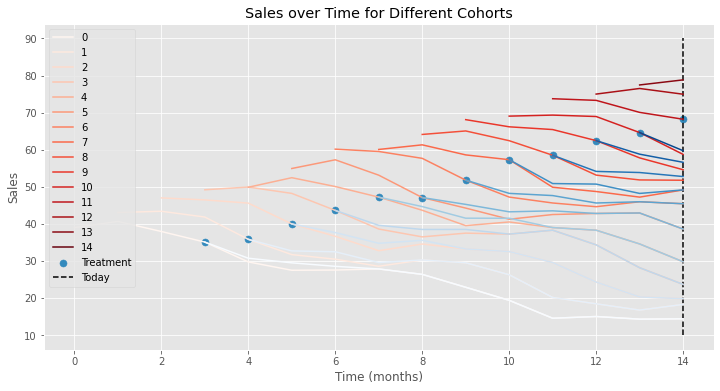

In [271]:
ax = cohorts.pivot("time", "cohort", "sales").plot(colormap="Reds", figsize=(12,6))
cohorts.query("treatment==1").plot.scatter(x="time", y="sales", ax=ax, s=50, label="Treatment")
plt.vlines(14, 10, 90, label="Today", linestyles="dashed", color="black")
plt.legend()
plt.title("Sales over Time for Different Cohorts")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = cohorts.query("treated==1").pivot("time", "cohort", "treated_sales").plot(colormap="Blues", ax=ax, legend=False);
plt.ylabel("Sales")
plt.xlabel("Time (months)");


Lot's of things are happening in this figure, so leat's break it donw because it's important. First, the treatment is applied once a customer reaches a 3 month tenure. This means that, on today's month, we haven't yet given the treatment to customers from cohorts 14 and 13 (the newer ones) and we've just given it to customers in the 12th cohort. Also, we gave the treatment to a random set of customers within a cohort. For this reason, we can see in shades of blue, the outcome \\(Y_1\\) from treated units, after the treatment. 

Finally, notice that the treatment effect is not instantaneous, but it spams what looks like a 4 month period, peaking at around 2 months after the treatment. This is important, because, although we've given the treatment to cohorts 12, 11, 10 and 9, we haven't seen their treatment effect in its entirety. 

Now, let me ask you, out of all the cohorts, which one do we want to know the treatment effect the most? The ones that haven't been treated yet, of course! In the industy, causal inference is a normative science. We use it to act. In other words, we want to know if we should treat or not. So, old cohorts don't matter anymore. There is no decision to be made there anymore. Rather, we wish to know how untreatd and even future cohorts (customer that will join the company in the future), will behave. That puts yet another complication when we wish to deal with treatment effect over time: we have less information about the customers we care the most about. This means we will have to be extra smart about how we use data. We know how past cohorts behave, but we really care about new and future cohorts. So we will have to infer the treatment effect on the past and extrapolate it to the future. And as good causal inference practitioners, we all know how extrapolation is dangerous and how carefull we have to be about it. 

Before we close on the cohort view, I just wanted to point out a tranformed veiw that might be a bit more usefull to us. The figure above is what we call **horizontal timing**. It has calendar month on the x axis, meaning newer cohorts will only have data in the right portion of the pannel. Also, as we've seen, treatments that are assigned at a momen in the custumer lifecicle instead of in a particular point in time get missaligned. This horizontal view is good for inspecting how cohorts compare to each other, but its a bit confusing if we wish to know how customers evolve along their lifetime in the company. For that, instead, we can use a **vertical timing** view.

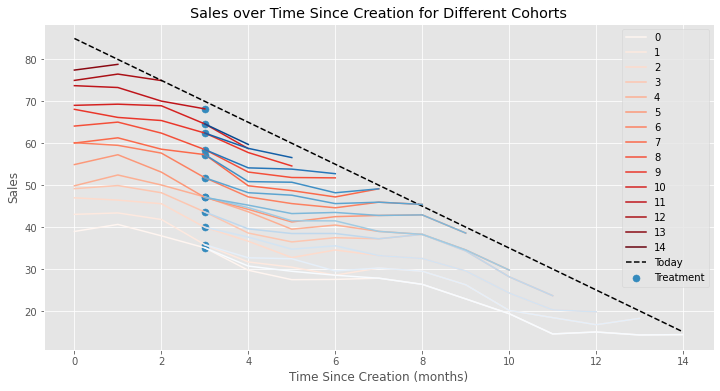

In [277]:
ax = cohorts.pivot("time_since_creation", "cohort", "sales").plot(colormap="Reds", figsize=(12,6))
ax = cohorts.query("treatment==1").plot.scatter(x="time_since_creation", y="sales", ax=ax, s=50, label="Treatment")

plt.plot([0, 14], [85, 15], label="Today", ls="dashed", color="black")

plt.legend()
plt.title("Sales over Time Since Creation for Different Cohorts")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = cohorts.query("treated==1").pivot("time_since_creation", "cohort", "treated_sales").plot(colormap="Blues", ax=ax, legend=False);
plt.ylabel("Sales")
plt.xlabel("Time Since Creation (months)");


In this view, we replace time with time since the customer joined the company (time since creatig). This alligns the customer moment in the company across all cohort. As a result, the treatment that is applied at the 3rd month also gets alligned. Again, this verital view isn't better than the horizontal one. It is just more usefull if we with to track how customers evolve in the company. But we sort of loose track of where today is in the plot. I've tried to show it in a dashed line, but that's only a guess. 

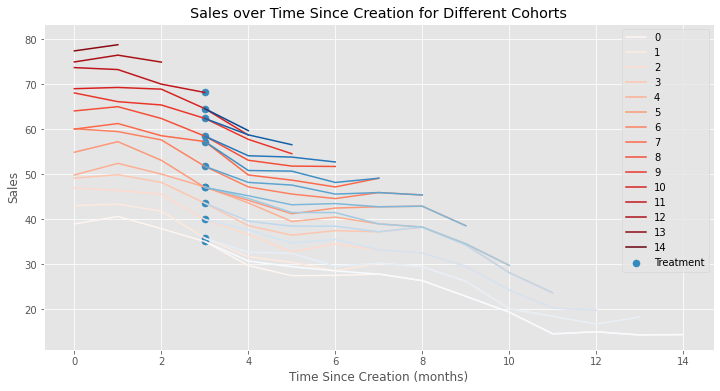

In [282]:
ax = cohorts.pivot("time_since_creation", "cohort", "sales").plot(colormap="Reds", figsize=(12,6))
ax = cohorts.query("treatment==1").plot.scatter(x="time_since_creation", y="sales", ax=ax, s=50, label="Treatment")

plt.legend()
plt.title("Sales over Time Since Creation for Different Cohorts")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = cohorts.query("treated==1").pivot("time_since_creation", "cohort", "treated_sales").plot(colormap="Blues", ax=ax, legend=False);
plt.ylabel("Sales")
plt.xlabel("Time Since Creation (months)");


In [286]:
cohorts["treated_sales"].mean() - cohorts["sales"].mean()

0.3333333333333499